## Load Audio Files
- Implements preprocessing and feature extraction scheme from the following paper: https://www.scitepress.org/Papers/2013/42344/42344.pdf
- Code taken from lindawangg/Classifying-Heartbeats
- Start with dataset A, which has 176 WAV files

In [1]:
# load in csv file
import csv
import numpy as np
import wave
import struct
from scipy import *
from utils import *

x_trainAFile = [] # wave filename 
y_trainA = [] # label 

# ignores all entries without a label
with open('set_a.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if not row[2]=='' and not row[2]=='label': 
            if moreNsecs(row[1],2):
                x_trainAFile.append(row[1])
                y_trainA.append(row[2])
print(len(x_trainAFile))

120


In [2]:
# dataset A, import sound files
x_trainA_raw = [] # features
for i in range(len(x_trainAFile)):
    x_trainA_raw.append(np.array(get_signal(x_trainAFile[i])))
x_trainA_raw = np.array(x_trainA_raw)
print(x_trainA_raw.shape)

(120, 2)


In [3]:
(x_trainA_raw[1][0]).shape

(396900,)

## Preprocessing

In [4]:
from scipy import signal
import copy

# Decimate signals by factor 5 via a lowpass, order 8, IIR Chebyshev type I filter 
decimate_factor = 5
X_trainA = copy.copy(x_trainA_raw)

for i in range(X_trainA.shape[0]):
    X_trainA[i][0] = np.array(signal.decimate(X_trainA[i][0], decimate_factor, ftype="fir"))

In [5]:
# Check if sampling rates are all the same
assert np.unique(X_trainA[:, 1]).shape[0] == 1
Fs = int(np.unique(X_trainA[:, 1]))/decimate_factor
print("Sampling Rate:", Fs, "Hz")
nyquist = Fs/2
print("Nyquist Frequency:", nyquist, "Hz")

Sampling Rate: 8820.0 Hz
Nyquist Frequency: 4410.0 Hz


In [6]:
# We no longer need sampling rates
X_trainA_ = copy.copy(X_trainA)
X_trainA_ = np.array([i[0] for i in X_trainA])

In [7]:
# # Apply band-pass filter:
# # 5th order Chebyshev type I band-pass filter w/ cutoff from 100 Hz to 882 Hz

# cut_low = 100
# cut_high = 882

# sos = signal.cheby1(
#     N=5, # order 5
#     rp=5, # not sure what to use for this value
#     Wn=[cut_low, cut_high],
#     btype='bandpass',
#     output='sos',
#     fs=Fs
# )

# X_trainA_filt = copy.copy(X_trainA_)
# X_trainA_filt = np.array([signal.sosfilt(sos, i) for i in X_trainA_filt])
    
# sig =  X_trainA_[90]
# filtered = X_trainA_filt[90]

# plot(sig)
# plot(filtered, 'r')

## DWT
- Uses wavelets to first denoise/smooth the signal before identifying peaks
- Wavelets are a linear transform whose basis functions are all scaled/shifted versions of a "mother function" 
- Creates a sparse representation of a signal (matrix of mainly 0's with some large magnitude coefficients)
- Coefficients with low values are considered noise and removed
- http://www.peterjbentley.com/heartworkshop/challengepaper3.pdf

- Leads to better peak identification and signal denoising than using a Chebyshev bandpass filter

In [8]:
import pywt

# 4th-level Order Six Daubechies filter
X_trainA_filt = copy.copy(X_trainA_)
X_trainA_filt = np.array([pywt.dwt(x,'db4')[0] for x in X_trainA_filt])

# Downsampled by factor 2 b/c of DWT
print("Size before DWT:", len(X_trainA_[0]))
print("Size after DWT:", len(X_trainA_filt[0]))

Size before DWT: 79380
Size after DWT: 39693


Text(0.5, 1.0, 'normal - After DWT')

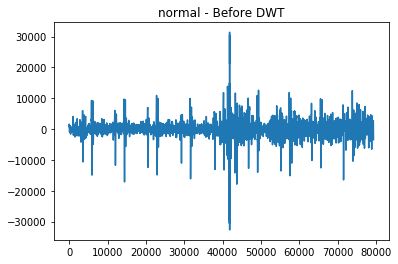

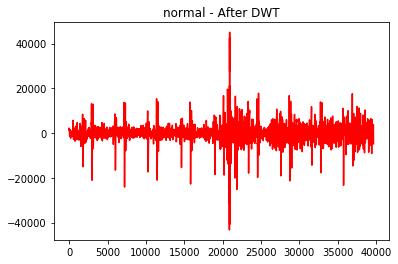

In [9]:
n = 90
sig =  X_trainA_[n]
filt = X_trainA_filt[n]

figure()
plot(sig)
title(str(y_trainA[n] + ' - Before DWT'))
      
figure()
plot(filt, 'r')
title(str(y_trainA[n] + ' - After DWT'))

Text(0.5, 1.0, 'normal - Normalized')

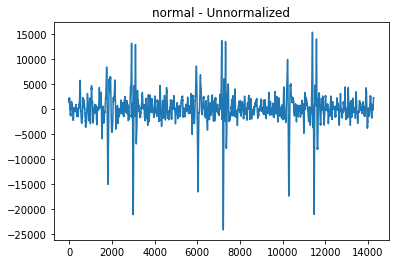

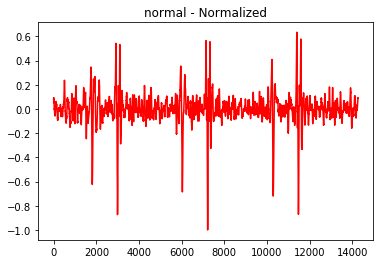

In [10]:
# Normalize signal lengths
X_trainA_norm = copy.copy(X_trainA_filt)
min_length = min(map(len, X_trainA_norm))
X_trainA_norm = np.array([x[:min_length] for x in X_trainA_norm])

# Normalize signal amplitudes
X_trainA_norm = np.array([x/max(np.abs(x)) for x in X_trainA_norm])

sig =  X_trainA_filt[n][:min_length]
sig_norm = X_trainA_norm[n]

figure()
plot(sig)
title(str(y_trainA[n] + ' - Unnormalized'))
      
figure()
plot(sig_norm, 'r')
title(str(y_trainA[n] + ' - Normalized'))

## Feature Extraction

### Peak Extraction:
- Identifies spikes above 15% of the signals' normalized amplitude
- https://lindawangg.github.io/projects/classifying-heartbeats.pdf

In [11]:
all_peaks = find_peaks(X_trainA_norm, 'A')

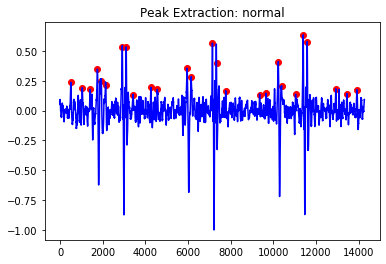

In [12]:
figure()
title(str("Peak Extraction: " + y_trainA[n]))
plot(X_trainA_norm[n],'b')
scatter(all_peaks[n],X_trainA_norm[n][all_peaks[n]],c='r')
show()

### Identify S1-S2 Boundaries
- Systolic period is shorter than the diastolic period: https://www.ncbi.nlm.nih.gov/books/NBK333/
- Diastole: Max difference b/w two peaks
- S2: First peak
- S1: Second peak
- Boundaries taken from: https://lindawangg.github.io/projects/classifying-heartbeats.pdf
- Based on http://www.peterjbentley.com/heartworkshop/challengepaper3.pdf

### Extract peak-related features (Time domain):
1. Number of peaks
2. Mean time b/w peaks
3. Mean amplitude of peaks
4. Smallest peak
5. Largest peak

In [56]:
#function for plotting class specific points of a feature
def featurePlot(feat, set_name, t):
    if set_name.upper() == 'A':
        print("Red=artifacts, blue=extrahls, purple=murmur, cyan=normal")
        for i in range(len(feat)):
            if y_trainA[i] == 'artifact':
                scatter(i,feat[i], c='r')
            elif y_trainA[i] == 'extrahls':
                scatter(i,feat[i], c='b')
            elif y_trainA[i] == 'murmur':
                scatter(i,feat[i], c='m')
            elif y_trainA[i] == 'normal':
                scatter(i,feat[i], c='c')
        title(t)
        show()

In [ ]:
features = get_features(X_trainA_norm, all_peaks)

In [55]:
num_peaks = features[:, 0]
avg_between = features[:, 1]
avg_strength = features[:, 2]
min_peak = features[:, 3]
max_peak = features[:, 4]

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


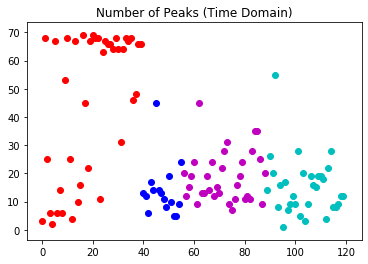

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


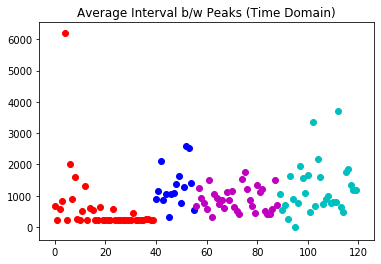

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


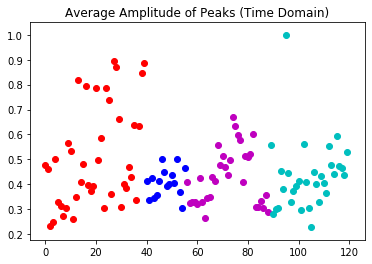

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


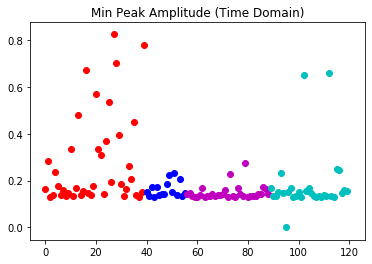

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


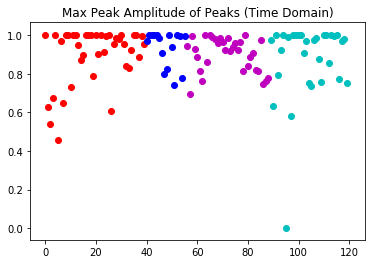

In [60]:
featurePlot(num_peaks, 'A', 'Number of Peaks (Time Domain)')
featurePlot(avg_between, 'A', 'Average Interval b/w Peaks (Time Domain)')
featurePlot(avg_strength, 'A', 'Average Amplitude of Peaks (Time Domain)')
featurePlot(min_peak, 'A', 'Min Peak Amplitude (Time Domain)')
featurePlot(max_peak, 'A', 'Max Peak Amplitude of Peaks (Time Domain)')

### STD's of S1 and S2 in Time Domain

In [62]:
s1_boundsA, s2_boundsA, s1s2_peaks = get_S1S2_bounds(X_trainA_norm, all_peaks, 'A')

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


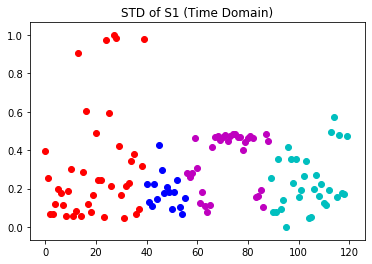

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


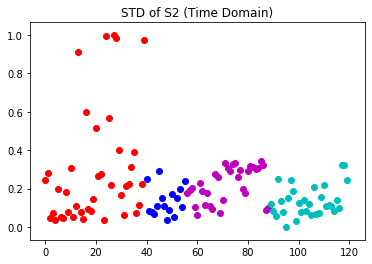

In [16]:
# Standard deviation of S1
stdS1_A = stdInterval_(s1_boundsA, 0, s1_boundsA, 1, X_trainA_norm)
stdS1_A = stdS1_A/max(stdS1_A)
title_1 = "STD of S1 (Time Domain)"
featurePlot(stdS1_A, 'A', title_1)

# Standard deviation of S2 normalized 
stdS2_A = stdInterval(s2_boundsA,0, s2_boundsA,1, X_trainA_norm)
stdS2_A = stdS2_A/max(stdS2_A)
title_2 = "STD of S2 (Time Domain)"
featurePlot(stdS2_A, 'A', title_2)

### Mean Distance b/w S1 and S2 Intervals

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


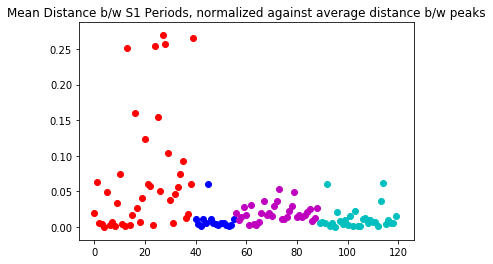

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


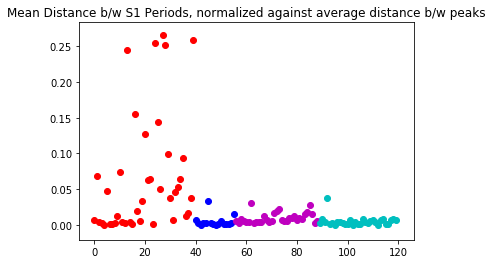

In [71]:
def Mean(data, s1s2_peaks, lower, upper):
    mean = []
    for k in range(len(data)):
        if np.isnan(s1s2_peaks[k][0]):
            mean.append([0])
        else:
            signal = abs(data)
            mean.append([(np.mean(signal[k][lower[k][0]:upper[k][1]]))*100]/avg_between[k])
    return mean

mean_s1 = Mean(X_trainA_norm, s1s2_peaks, s1_boundsA, s1_boundsA)
featurePlot(mean_s1, 'A', 'Mean Distance b/w S1 Periods, normalized against average distance b/w peaks')

mean_s2 = Mean(X_trainA_norm, s1s2_peaks, s2_boundsA, s2_boundsA)
featurePlot(mean_s2, 'A', 'Mean Distance b/w S1 Periods, normalized against average distance b/w peaks')

### Signal Energy (Time domain)

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


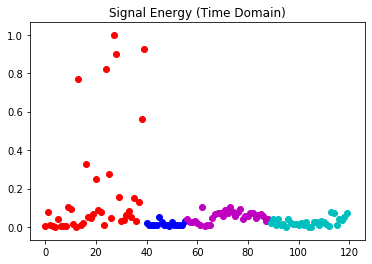

In [17]:
# Sum of squares of the signal values
energyA = np.array([sum(abs(x)**2) for x in X_trainA_norm])
energyA = energyA/max(energyA)

featurePlot(energyA, 'A', 'Signal Energy (Time Domain)')

### Rmedian
- Median of three largest peaks / total mean 

In [108]:
def R_median(data):
    r_medians = []
    for k in range(len(data)):
        if len(data[k]) >= 3:
            sorted_data = sorted(data[k])
            top_peaks = sorted_data[-3:]
            r_medians.append(np.median(top_peaks)/avg_strength[k])
        else: 
            r_medians.append(0)
    return r_medians

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


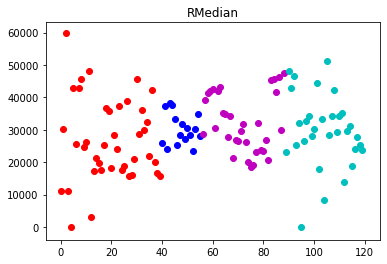

In [135]:
r_medians = R_median(all_peaks)
featurePlot(r_medians, 'A', 'RMedian')

### R^2:
- R^2 value for sorted segments

In [121]:
def R_squared(data):
    r2_vals = []
    for k in range(len(data)):
        if len(data[k]) > 1: 
            sorted_data = sorted(data[k])
            x_vals = range(1, len(sorted_data) + 1)
            
            correlation_matrix = np.corrcoef(x_vals, sorted_data)
            correlation_xy = correlation_matrix[0,1]
            r2_vals.append(correlation_xy**2)
        else: 
            r2_vals.append(0)
    return r2_vals

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


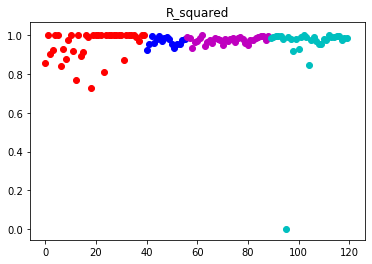

In [123]:
r2_vals = R_squared(all_peaks)
featurePlot(r2_vals, 'A', 'R_squared')

In [134]:
len(r_medians)

121

In [139]:
import pandas as pd

signals_df = pd.DataFrame(
    {
        "Number of Peaks" : num_peaks,
        "Average Distance b/w Peaks" : avg_between,
        "Average Peak Amplitude" : avg_strength,
        "Minimum Peak" : min_peak,
        "Maximuim Peak" : max_peak,
        "STD S1" : stdS1_A,
        "STD S2" : stdS2_A,
        "Mean S1 Distance" : mean_s1,
        "Mean S2 Distance" : mean_s2,
        "Signal Energy" : energyA,
        "R median" : r_medians,
        "R_squared" : r2_vals
    }
)
print(signals_df.shape)
signals_df.head()

(120, 12)


,Number of Peaks,Average Distance b/w Peaks,Average Peak Amplitude,Minimum Peak,Maximuim Peak,STD S1,STD S2,Mean S1 Distance,Mean S2 Distance,Signal Energy,R median,R_squared
0,3,687,0.47801,0.165481,1,0.393663,0.243244,[0.020234393357576857],[0.006895465088611316],0.006390,11133.650095,0.854506
1,68,208.433,0.461857,0.285954,0.625859,0.256124,0.280048,[0.06356161793280872],[0.06846028276124207],0.077940,30163.030459,0.999727
2,25,581.333,0.234127,0.130074,0.542295,0.067413,0.045401,[0.005422086462253448],[0.0036402589498917707],0.008348,59809.387334,0.905707
3,6,838.6,0.249356,0.138364,0.673262,0.070429,0.075147,[0.004349860599279982],[0.003254248819749788],0.003016,10968.265760,0.923671
4,2,6215,0.5,0.235704,1,0.120234,0.037671,[0.0004266152340556338],[0.0002485545709296344],0.001091,0.000000,1.000000
